# Продажи слабоалкогольной продукции в регионах России
Перед нами стоит задача: определить, в каких регионах России выгоднее всего продавать слабоалкогольную продукцию, и попытаться найти причины этого.

Мы изучим возможное влияние на продажи таких характеристик регионов, как:
- Возрастной состав населения.
- Безработица.
- Уровень дохода на одного человека.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

try:
    from toads.image import Img
except ModuleNotFoundError:
    !pip install --upgrade git+https://github.com/ivanrychkov/toads
finally:
    from toads.image import Img

    
plt.ioff()
sns.set_theme()
pd.set_option('max_columns', None)
warnings.filterwarnings('ignore')

---

## 1. Загрузка и предобработка данных
Все данные взяты из [ЕМИСС](https://www.fedstat.ru/).

#### Численность населения

In [2]:
male_pop, fem_pop = [pd.read_excel(f'{name}.xls', header=[1], skiprows=1, index_col=[0, 1], usecols=[0, 1, 10])
                     .reset_index()
                     .drop(0)
                     .rename({'level_0': 'age',
                              'level_1': 'district',
                              '2019': 'pop'}, axis=1)
                     .dropna(subset=['pop'])
                     .infer_objects()
                     for name in ['male_pop', 'fem_pop']]

# Обозначим пол
male_pop['gender'] = 'm'
fem_pop['gender'] = 'f'

# Объединим
pop = male_pop.append(fem_pop)
del male_pop, fem_pop

# Сделали категории из районов и полов
pop.district = pop.district.astype('category')
pop.gender = pop.gender.astype('category')

# Нашли возрастные диапазоны, которые нам интересны
pop.age = pop.age.str.extract(r'(\d+-\d+)', expand=False).str.replace('-', ' ')

# Удалили строки с ненужными возрастами
pop.dropna(subset=['age'], inplace=True)

# Перевели диапазоны возрастов в кортежи
pop.age = pop.age.apply(lambda s: tuple(map(int, s.split())))

# Удалили диапазоны != 4 годам
pop = pop.loc[(pop.age.apply(lambda x: x[1]) - pop.age.apply(lambda x: x[0]) == 4)]

# Получили суммарное население для каждого региона, оставшееся после удаления юнцов
pop_total = pop.groupby(['district', 'age']).agg({'pop': 'sum'})

# Подтянули общюю численность в датафрейм
pop = pop.merge(pop_total, on=['district','age'], suffixes=('','_total'))

# Делаем большую сводную таблицу
pop = pop.pivot_table(index='district', columns='age', values='pop_total')

# Удаляем общую численность для России
pop.drop('Российская Федерация', inplace=True)
# Удаляем федеральные округа, чтобы не плодить одно и то же
pop = pop.reindex(index=[i for i in pop.index if not ('федеральный' in i)])

# Присоединяем полное население
pop = pop.join(pop_total.reset_index().groupby('district').sum()).rename({'pop': 'pop_total'}, axis=1)

pop.info()
pop.head()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries,             Архангельская область (кроме Ненецкого автономного округа) to         Ярославская область
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   (0, 4)     87 non-null     int64
 1   (5, 9)     87 non-null     int64
 2   (10, 14)   87 non-null     int64
 3   (15, 19)   87 non-null     int64
 4   (20, 24)   87 non-null     int64
 5   (25, 29)   87 non-null     int64
 6   (30, 34)   87 non-null     int64
 7   (35, 39)   87 non-null     int64
 8   (40, 44)   87 non-null     int64
 9   (45, 49)   87 non-null     int64
 10  (50, 54)   87 non-null     int64
 11  (55, 59)   87 non-null     int64
 12  (60, 64)   87 non-null     int64
 13  (65, 69)   87 non-null     int64
 14  (70, 74)   87 non-null     int64
 15  (75, 79)   87 non-null     int64
 16  (80, 84)   87 non-null     int64
 17  (85, 89)   87 non-null     int64
 18  (90, 94)   87 non-null     int64
 19  (95, 

,"(0, 4)","(5, 9)","(10, 14)","(15, 19)","(20, 24)","(25, 29)","(30, 34)","(35, 39)","(40, 44)","(45, 49)","(50, 54)","(55, 59)","(60, 64)","(65, 69)","(70, 74)","(75, 79)","(80, 84)","(85, 89)","(90, 94)","(95, 99)",pop_total
district,,,,,,,,,,,,,,,,,,,,,
Архангельская область (кроме Ненецкого автономного округа),62567,68916,62560,53349,51538,62215,87682,87931,84702,71888,68997,83122,83753,68718,35410,28320,23195,10868,3943,540,1100214
Ненецкий автономный округ (Архангельская область),3611,3516,3081,2753,2321,2323,3696,3826,3379,2783,2667,3190,2692,1804,843,583,477,191,72,16,43824
Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа),114446,111461,88357,72711,73993,119896,148220,125054,105787,89171,84611,104753,98979,77379,36590,27578,24011,10880,4203,522,1518602
Ханты-Мансийский автономный округ - Югра (Тюменская область),126272,130753,108813,89926,83565,110229,161502,154628,136295,119547,109464,127211,95538,57965,23214,14025,9954,3416,1241,202,1663760
Ямало-Ненецкий автономный округ (Тюменская область),42045,42716,38007,31036,29001,32456,52754,53835,49225,44602,38766,41042,25850,12019,3919,2058,1307,550,229,53,541470


#### Продажи по регионам

In [3]:
# Открываем
sales = pd.read_excel('alco_sales.xls', index_col=[0, 1, 2], usecols=[0, 1, 2, 5], skiprows=2).droplevel(2).reorder_levels([1, 0]).reset_index().drop(0)

# Переименовали
sales.columns = 'district', 'type', 'volume'

# Удалили пропуски
sales.dropna(subset=['volume'], inplace=True)

# Привели типы данных
sales.type = sales.type.astype('category')
sales.volume = sales.volume.astype('float')

# Сделали сводную таблицу
sales = sales.pivot_table('volume', 'district', 'type').iloc[:, 0].rename('sales') * 10000

# Отсортировали под население
sales = sales.reindex_like(pop)

sales.head(2)

district
            Архангельская область (кроме Ненецкого автономного округа)          NaN
            Ненецкий автономный округ (Архангельская область)             2120940.0
Name: sales, dtype: float64

#### Уровень дохода

In [4]:
# Откроем данные о доходах
income = pd.read_excel('income.xls', usecols=[1, 2], index_col=0, skiprows=2, squeeze=True).rename('income').reindex_like(pop)
income.head(2)

district
            Архангельская область (кроме Ненецкого автономного округа)    247279.1
            Ненецкий автономный округ (Архангельская область)              37937.8
Name: income, dtype: float64

#### Безработица
У нас есть мысль, что спрос некоторых регионов на СА может быть вызван безработицей.

In [5]:
# Откроем данные о безработице
unemployed = ((pd.read_excel('unemployment.xls', skiprows=3, index_col=0, usecols=[1, 3], squeeze=True).reindex_like(pop) / 100)
              .rename('unemp_rate'))

unemployed.head(2)

district
            Архангельская область (кроме Ненецкого автономного округа)    0.062
            Ненецкий автономный округ (Архангельская область)             0.079
Name: unemp_rate, dtype: float64

#### Объединяем данные

In [6]:
# Присоединяем продажи на душу населения делением продаж на население и доход на душу населения. Удаляем пропуски.
data = pop.assign(income=income / pop.pop_total * 1000000,
                  unemployed=unemployed,
                  sales=sales / pop.pop_total).dropna()

cols = ['sales', 'income']
# Считаем процент каждой возрастной категории в регионе
data.iloc[:, :-3] = data.iloc[:, :-3].apply(lambda x: x / data.pop_total)

# Удаляем население
data.drop('pop_total', axis=1, inplace=True)

# Сортируем по убыванию
data.sort_values('sales', ascending=False, inplace=True)

data.head()

,"(0, 4)","(5, 9)","(10, 14)","(15, 19)","(20, 24)","(25, 29)","(30, 34)","(35, 39)","(40, 44)","(45, 49)","(50, 54)","(55, 59)","(60, 64)","(65, 69)","(70, 74)","(75, 79)","(80, 84)","(85, 89)","(90, 94)","(95, 99)",income,unemployed,sales
district,,,,,,,,,,,,,,,,,,,,,,,
Удмуртская Республика,0.065239,0.070900,0.058569,0.051033,0.046446,0.063650,0.083797,0.077177,0.072009,0.062339,0.060740,0.077473,0.073612,0.056567,0.028030,0.021713,0.018429,0.008885,0.003030,0.000364,173891.813859,0.043,105.208216
Республика Адыгея (Адыгея),0.061090,0.065350,0.059680,0.050034,0.053208,0.072216,0.081814,0.073399,0.067257,0.063421,0.060701,0.072660,0.065709,0.054925,0.030643,0.029517,0.024659,0.009294,0.003776,0.000647,97076.689613,0.082,89.344916
Республика Коми,0.063313,0.067850,0.060120,0.050722,0.047016,0.057554,0.083013,0.084890,0.079950,0.070619,0.066767,0.079031,0.069435,0.052194,0.024442,0.018775,0.015368,0.006456,0.002192,0.000293,315388.738526,0.068,82.130133
Еврейская автономная область,0.063846,0.068718,0.065609,0.053289,0.053120,0.068474,0.084090,0.080612,0.076885,0.068061,0.055228,0.064903,0.063996,0.057098,0.030269,0.022126,0.015447,0.005866,0.002051,0.000313,151645.705780,0.062,77.552486
Хабаровский край,0.065188,0.063386,0.052281,0.049219,0.056094,0.079881,0.091586,0.081579,0.074900,0.067617,0.057587,0.063111,0.059723,0.055031,0.033121,0.023772,0.017177,0.006166,0.002259,0.000321,303119.097205,0.038,77.285358


---

## 2. Анализ данных
У нас есть полные данные: теперь их можно проанализировать.

Посмотрим, есть ли явная корреляция между характеристиками регионов и продажами.

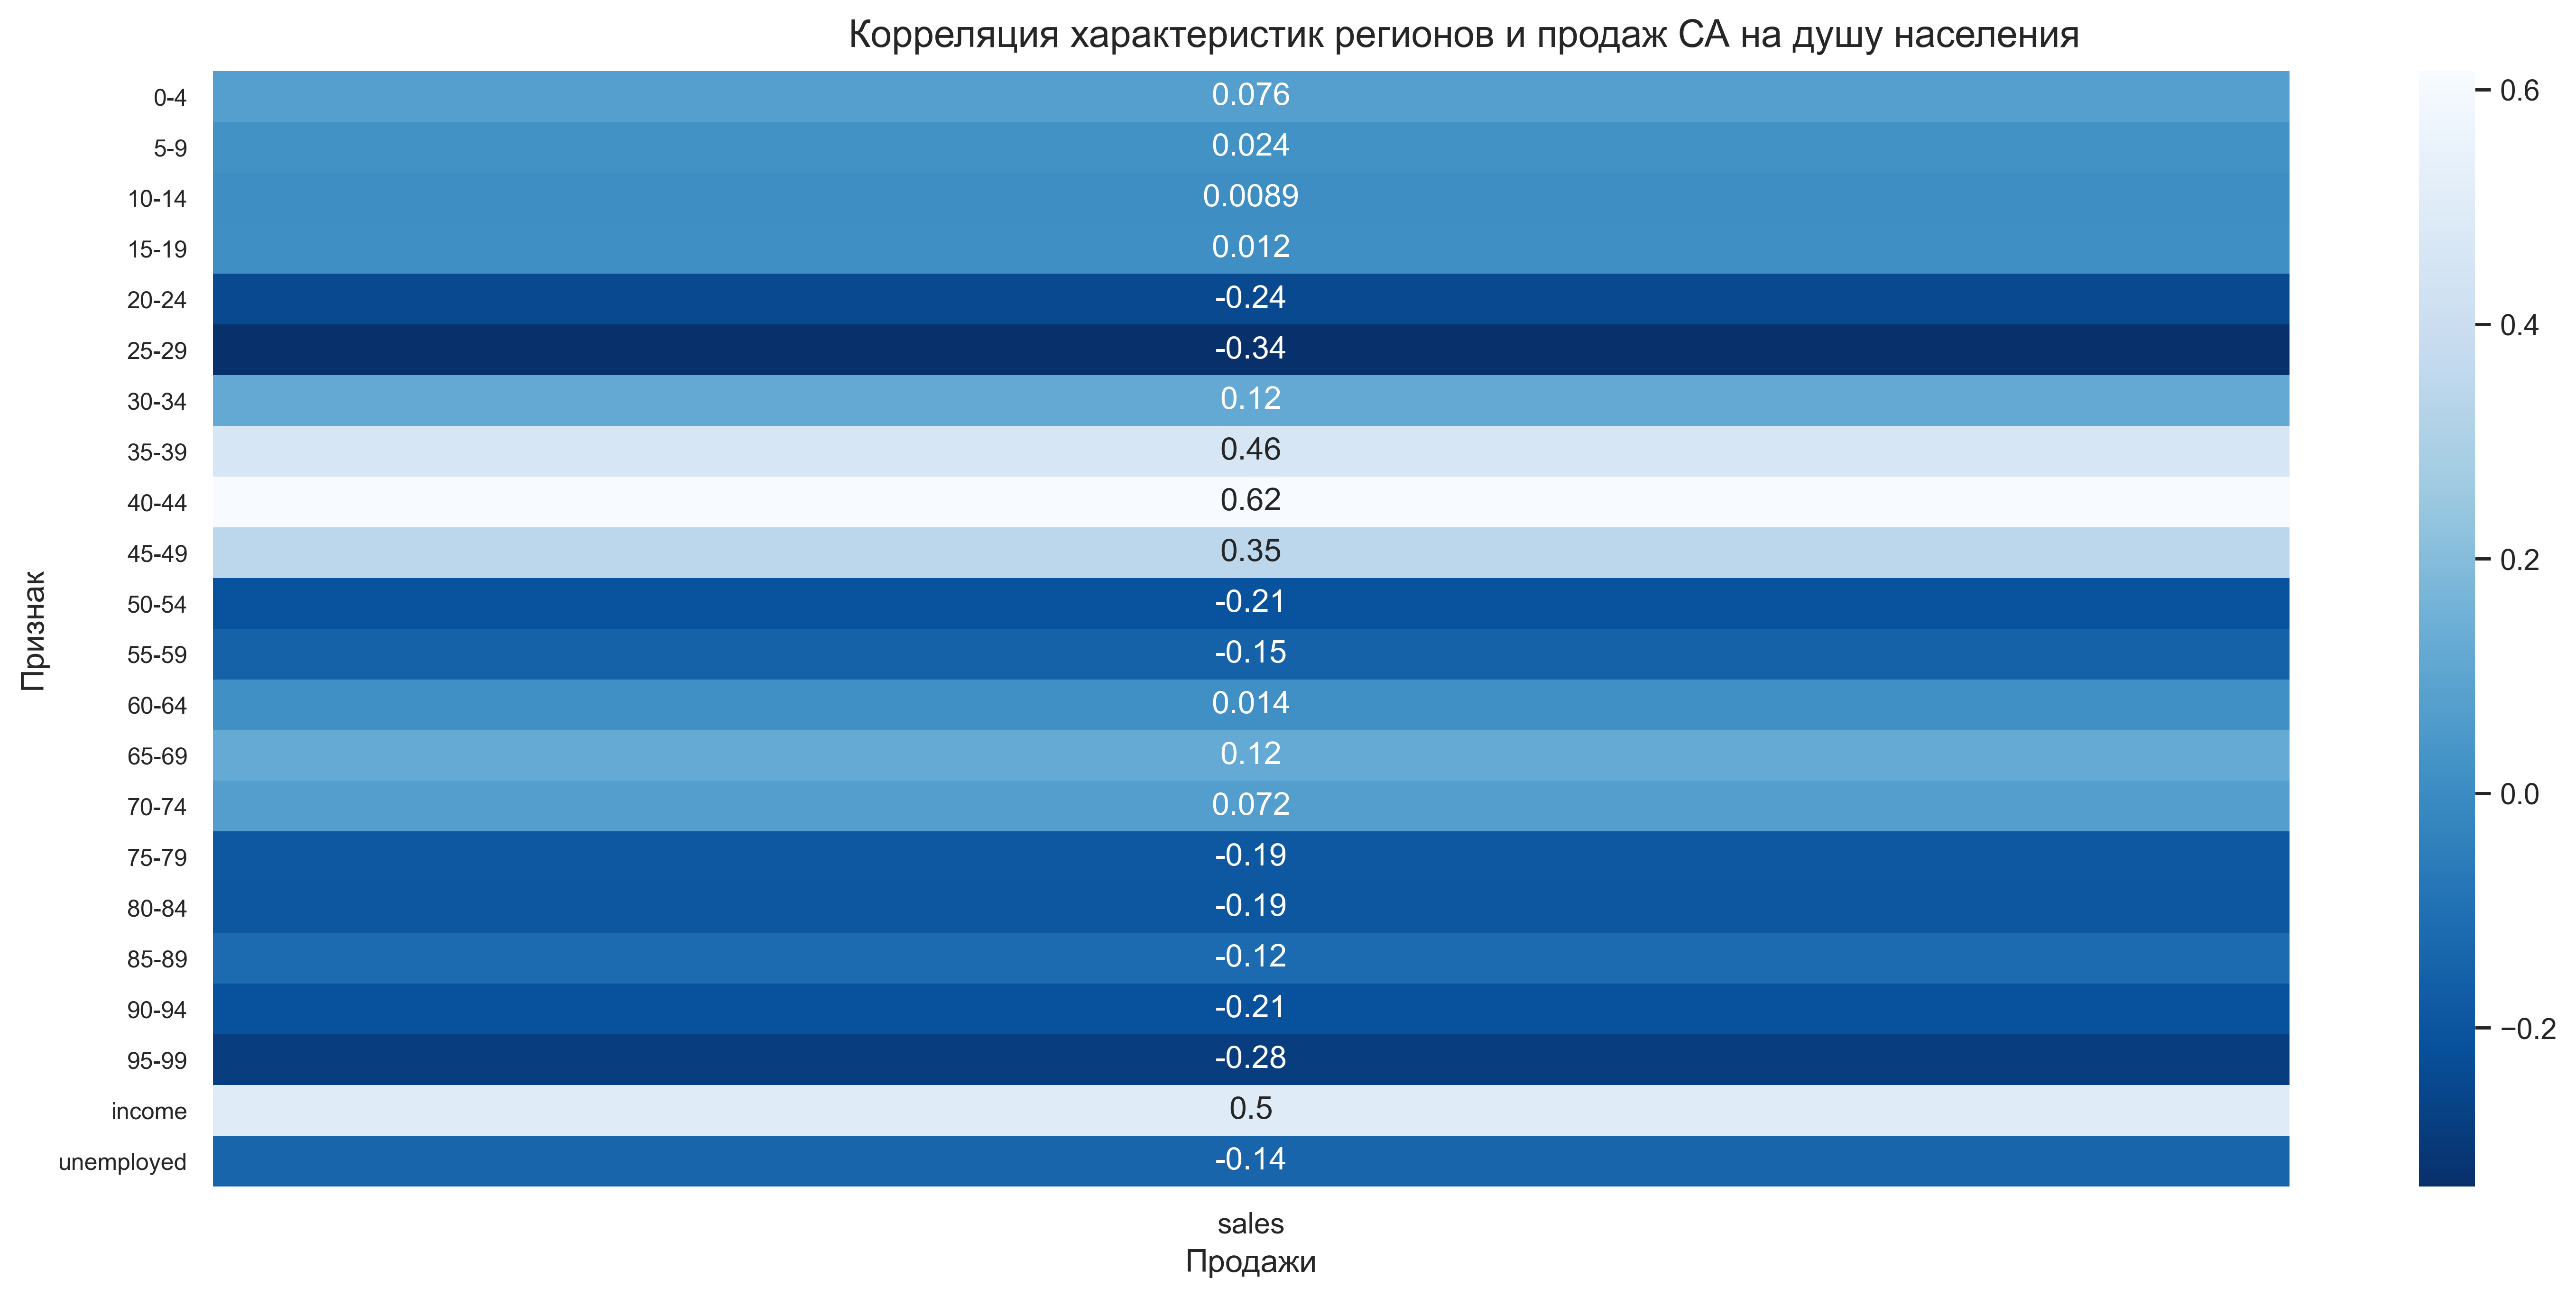

In [7]:
# Для красоты сделаем текстовые представления столбцов без скобок
str_cols = np.array([f'{x[0]}-{x[1]}' if isinstance(x, tuple) else x
                     for x in data.columns])

with Img('Корреляция характеристик регионов и продаж СА на душу населения', y=7, tight=True):
    corr = data.corr('spearman').iloc[:-1, -1:]
    sns.heatmap(corr, annot=True, cmap='Blues_r')
    Img.labels('Продажи', 'Признак')
    plt.yticks(ticks=np.arange(data.columns[:-1].shape[0]) + .5, labels=str_cols[:-1], size=9)
    del corr

- Самая заметная корреляция продаж с диапазоном 35-49 лет. 
- Можем предположить, что больше всего покупает СА население в районе 40-44 лет. А меньше всего - молодые люди до 30.
- Доход заметно коррелирует с продажами.
- А безработица - почти нет.

---

### Топ-10 регионов
Посмотрим, в каких округах из известных нам больше всего продажи на душу населения, и попробуем получить усреднённый состав по возрастам. Вдруг мы заметим закономерность?

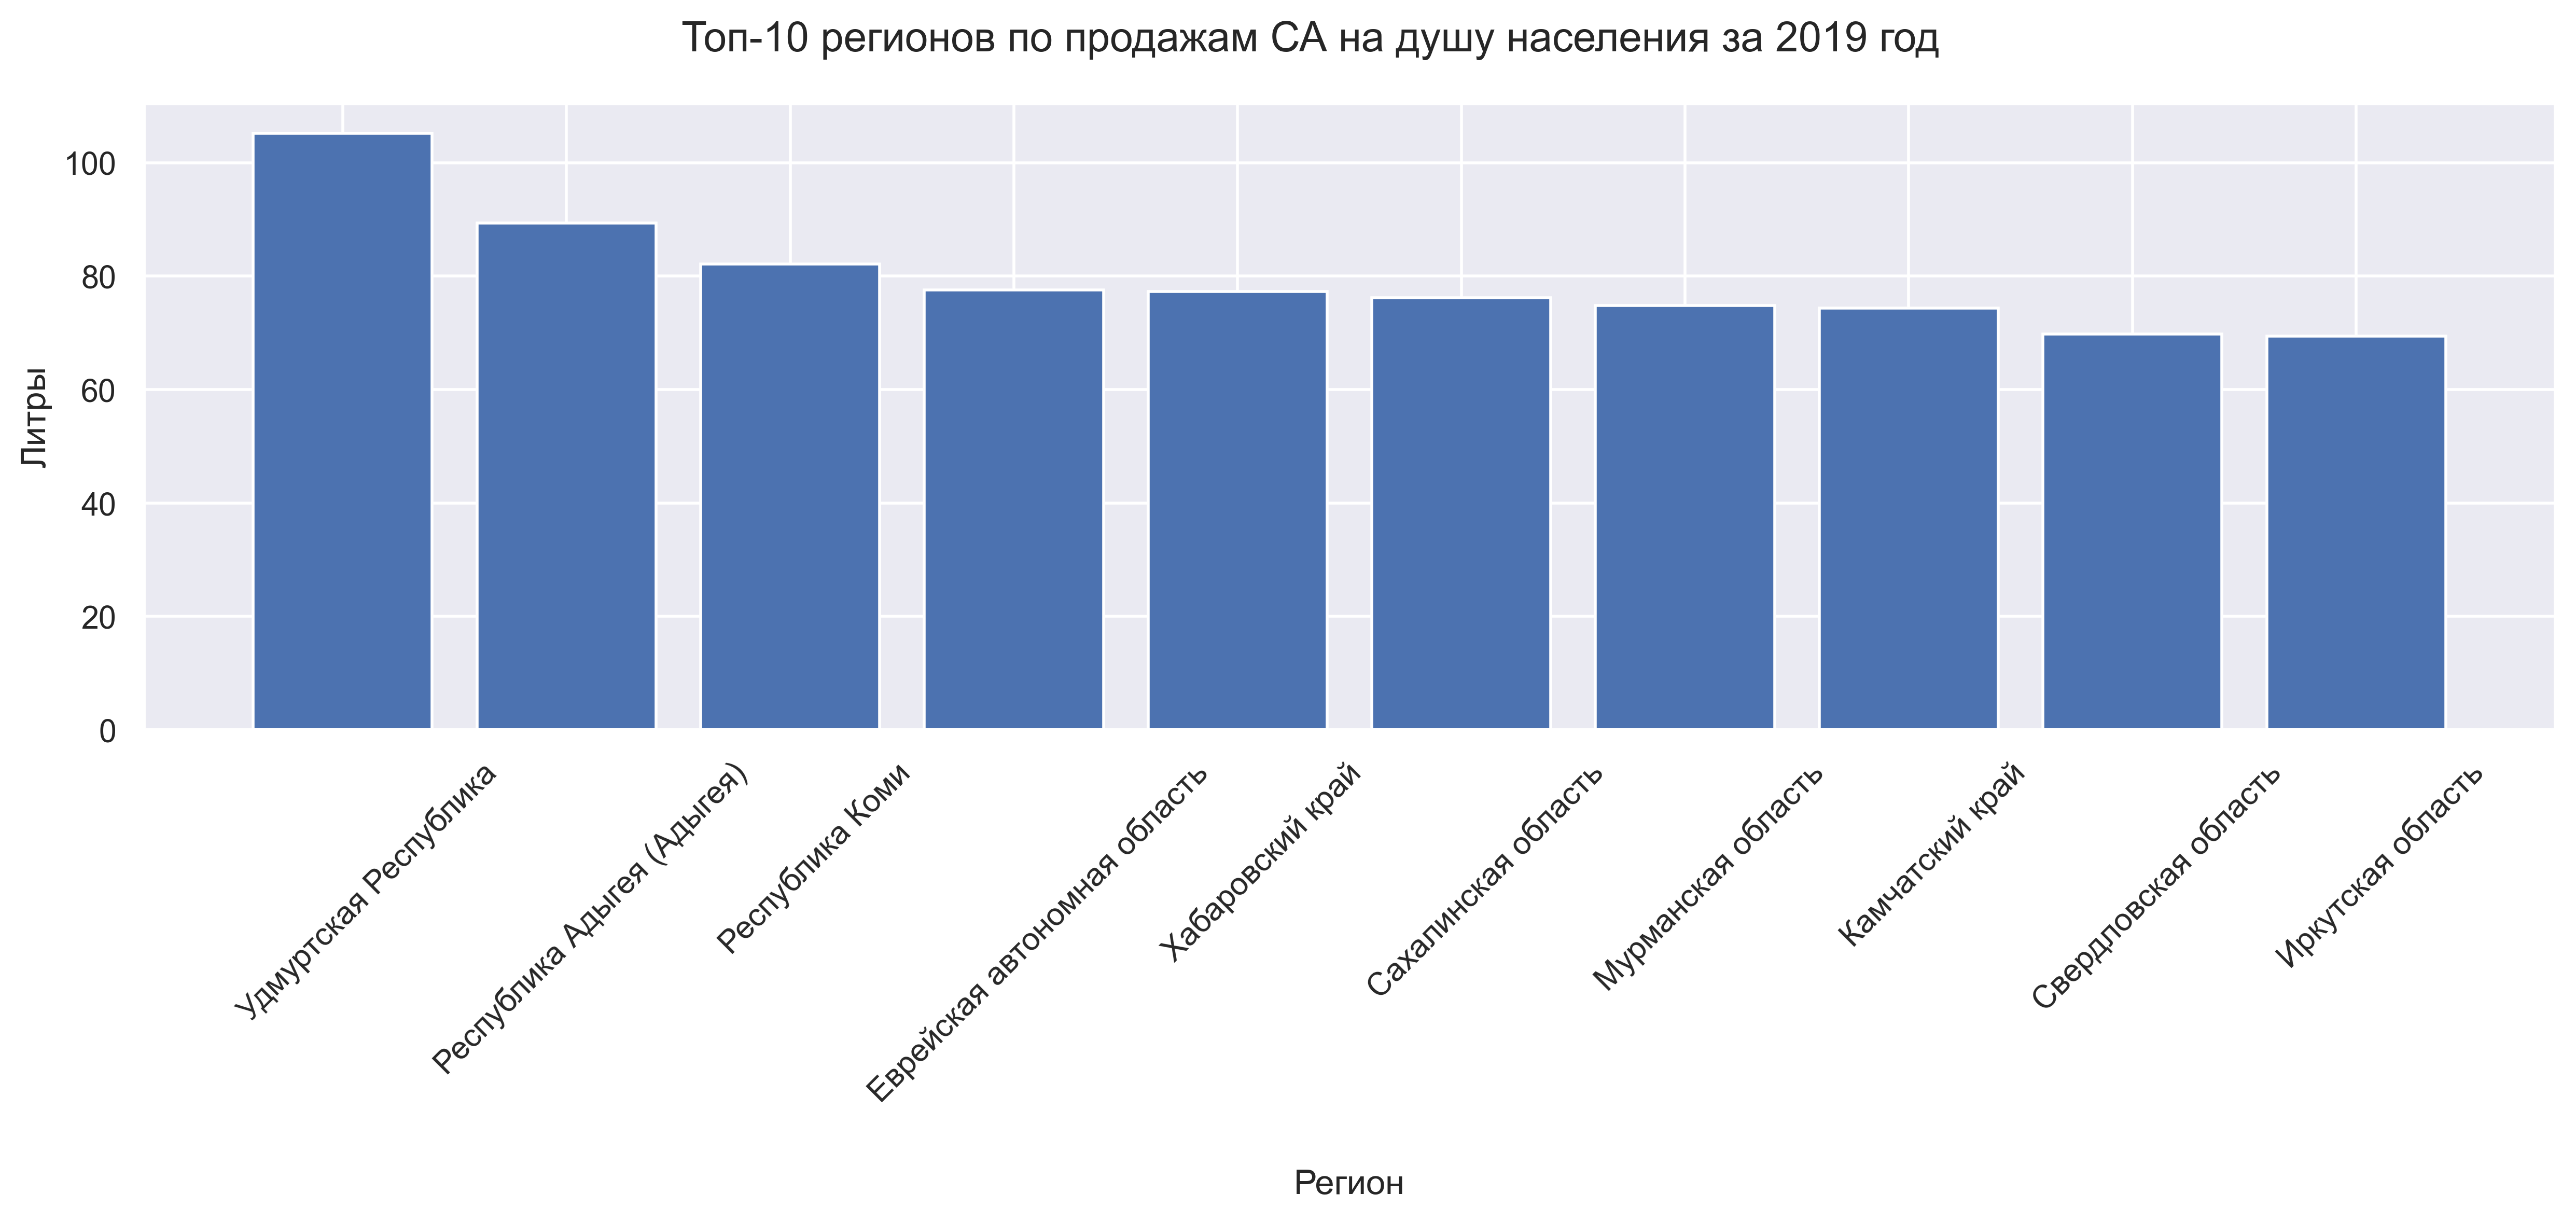

In [8]:
with Img('Топ-10 регионов по продажам СА на душу населения за 2019 год'):
    top_sales = data.head(10)
    plt.bar(x=top_sales.index, height=top_sales.sales)
    plt.xticks(rotation=45)
    Img.labels('Регион', 'Литры')

- Видим весьма отдалённые от центра регионы.

Какой у них возрастной состав?

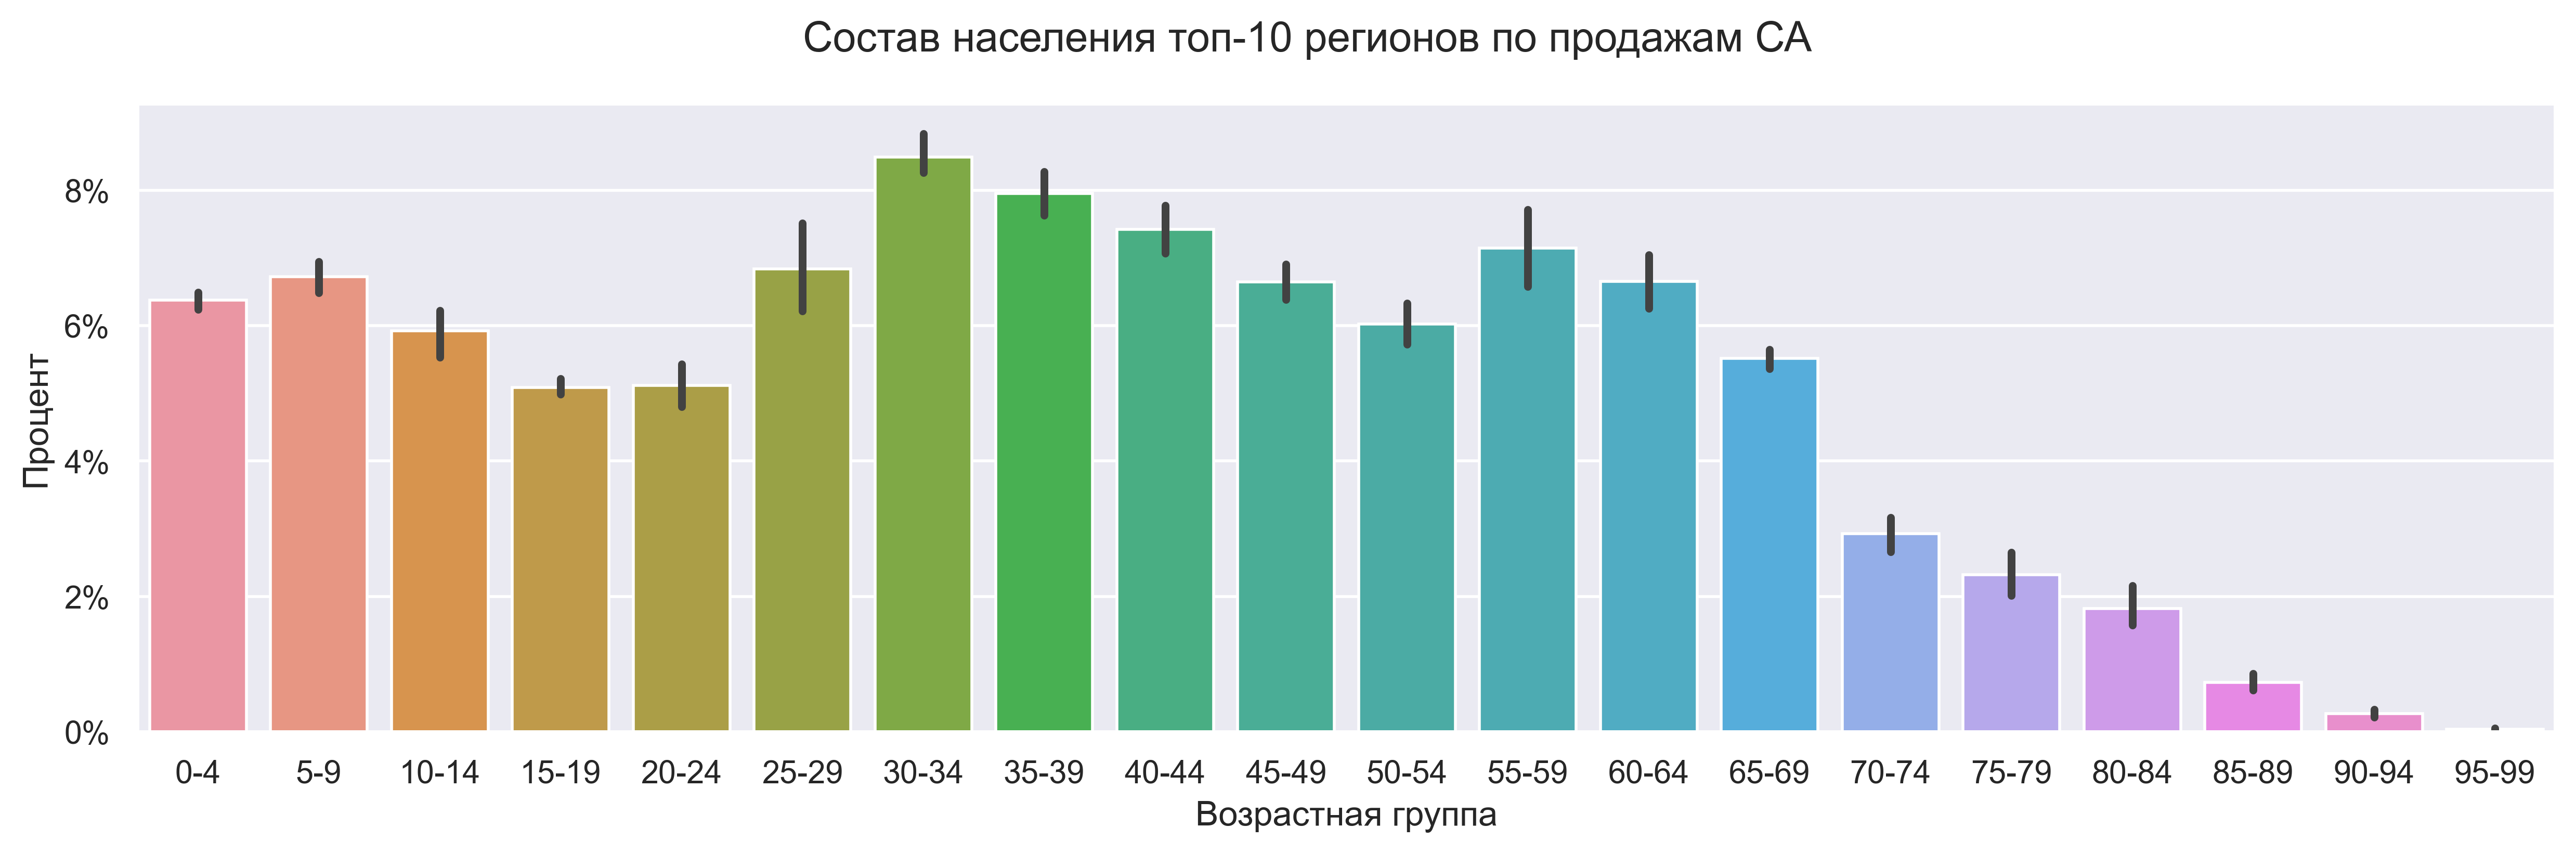

In [9]:
age_stat = data.drop(['sales', 'income', 'unemployed'], axis=1)

with Img('Состав населения топ-10 регионов по продажам СА'):
    sns.barplot(data=age_stat.head())
    Img.labels('Возрастная группа', 'Процент')
    plt.xticks(ticks=range(20), labels=str_cols[:-3])
    Img.format_axis(1)

А что у нас по всей России?

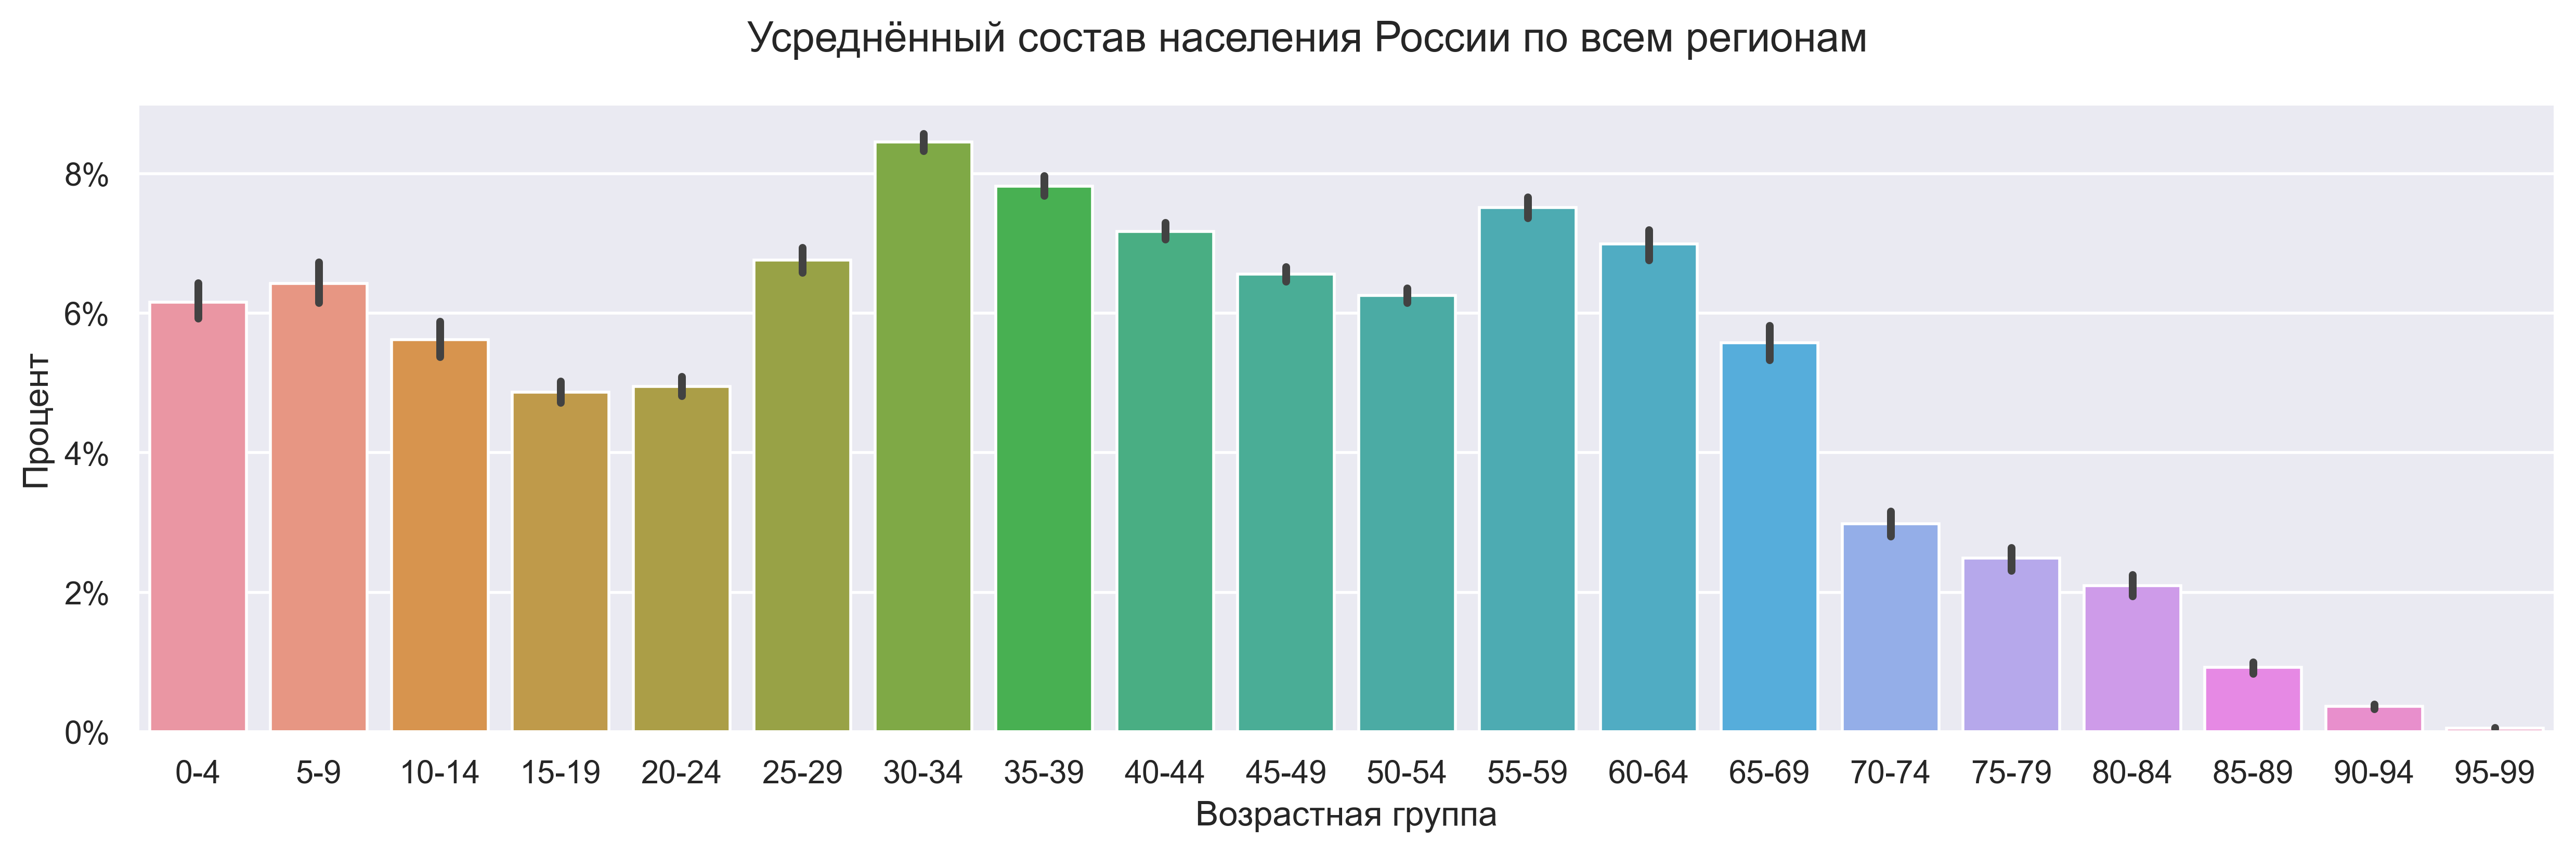

In [10]:
with Img('Усреднённый состав населения России по всем регионам'):
    sns.barplot(data=age_stat.drop(top_sales.index))
    Img.labels('Возрастная группа', 'Процент')
    plt.xticks(ticks=range(20), labels=str_cols[:-3])
    Img.format_axis(1)

- Графики сильно похожи. Есть ли между ними реальная разница? Визуально это не определить. Проверим гипотезу о равенстве выборок.

### Проверка гипотезы о сходстве возрастных групп
$H_0$: Предположим по умолчанию, что у нас нет различий в численности населения в каждой возрастной категории между топ-10 регионов и всей страной в целом.

In [11]:
from toads.stats import hypo
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

Проверим распределения возрастов на нормальность, чтобы подобрать верный критерий сравнения.

In [12]:
f'{sum([hypo(shapiro(data[col]), verbose=False) for col in top_sales.columns]) / data.columns.shape[0]:.2%} нормальных распределений'

'17.39% нормальных распределений'

Далеко не все распределения оказались нормальными, а значит, что для нас будет надёжнее тест Манна-Уитни.

Узнаем, доля каких возрастных групп в продающих регионах явно отличается в ту или иную сторону.

In [13]:
# Проверим сходство каждого столбца тестом Манна-Уитни
diff_dict = {col: hypo(mannwhitneyu(top_sales[col], data.drop(top_sales.index)[col]), verbose=False)
             for col in top_sales.columns}
diff_dict

{(0, 4): False,
 (5, 9): True,
 (10, 14): False,
 (15, 19): False,
 (20, 24): False,
 (25, 29): True,
 (30, 34): True,
 (35, 39): False,
 (40, 44): False,
 (45, 49): True,
 (50, 54): True,
 (55, 59): False,
 (60, 64): False,
 (65, 69): True,
 (70, 74): True,
 (75, 79): False,
 (80, 84): False,
 (85, 89): False,
 (90, 94): False,
 (95, 99): False,
 'income': False,
 'unemployed': True,
 'sales': False}

- Обращаем внимание, что 35-44 годовалая категория, которую мы заметили при анализе корреляции, действительно отличается в топ-10. Мы только что нашли **закономерность**!
- Интересно, что сюда же попали **подростки 10-19 лет**. Вполне возможно, что кто-то хочет почувствовать себя взрослым раньше времени.
- Доля младенцев - тоже интересный признак. Возможно, что родители предпочитают СА, чтобы расслабиться.

Сколько составила приблизительная разница в долях наших категорий?

In [14]:
# Посчитаем примерную разницу в процентах
groups_of_interest = [key
                      for key, value in diff_dict.items() if not value and isinstance(key, tuple)]
(top_sales[groups_of_interest].mean() - data.drop(top_sales.index)[groups_of_interest].mean()).apply('{:.2%}'.format)

(0, 4)       0.27%
(10, 14)     0.18%
(15, 19)     0.17%
(20, 24)     0.17%
(35, 39)     0.33%
(40, 44)     0.45%
(55, 59)    -0.44%
(60, 64)    -0.40%
(75, 79)    -0.28%
(80, 84)    -0.38%
(85, 89)    -0.25%
(90, 94)    -0.12%
(95, 99)    -0.02%
dtype: object

- Не такая большая разница в процентах, но если посчитать различие в количестве людей-потенциальных клиентов, то это может быть существенно.
- В целом мы видим, что в продающих регионах больше людей возрастом до 45 и меньше - от 55. По всей видимости, люди постарше предпочитают более взрослые напитки.

---

### Безработица
- У нас есть предположение, что спрос некоторых регионов на СА может быть вызван безработицей.
- Пока что мы видели отрицательную корреляцию. Неужели продажи алкоголя обратно пропорциональны уровню безработицы?

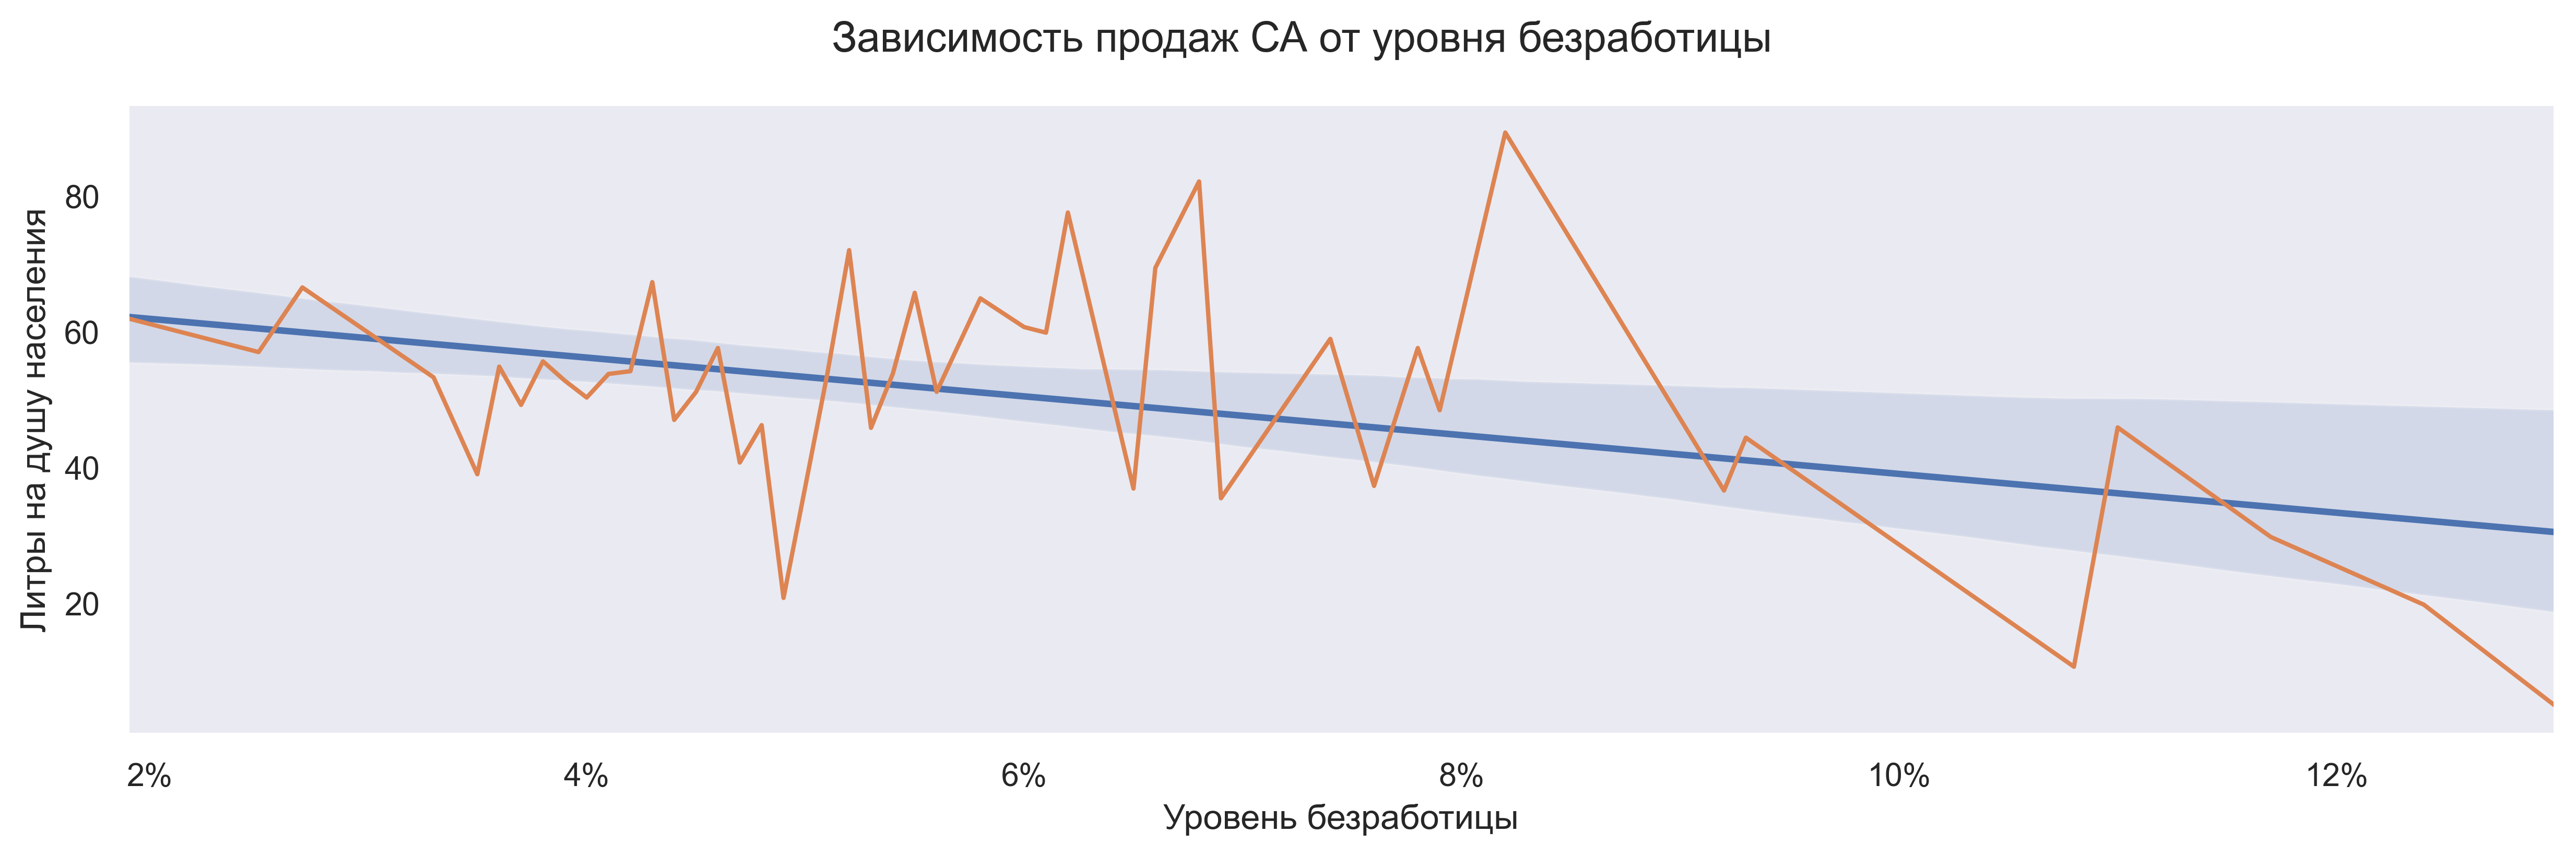

In [15]:
with Img('Зависимость продаж СА от уровня безработицы', grid=True):
    sns.regplot(x=data.unemployed, y=data.sales, ci=95, scatter=False)
    sns.lineplot(x=data.unemployed, y=data.sales, ci=None)
    Img.labels('Уровень безработицы', 'Литры на душу населения')
    Img.format_axis(0)

- Как видим, сложно доказать, что безработица способствует продажам нашей продукции.
- Скорее даже наоборот: начиная с 9% безработицы продажи слабоалкоголя снижаются особенно заметно. Возможно, что люди в таких ситуациях уже предпочитают напитки покрепче.

---

### Уровень дохода
- До этого мы видели ощутимую корреляцию дохода и продаж. Вполне логично: платёжеспособность позволяет покупать больше.

Посмотрим, как это выглядит на графике.

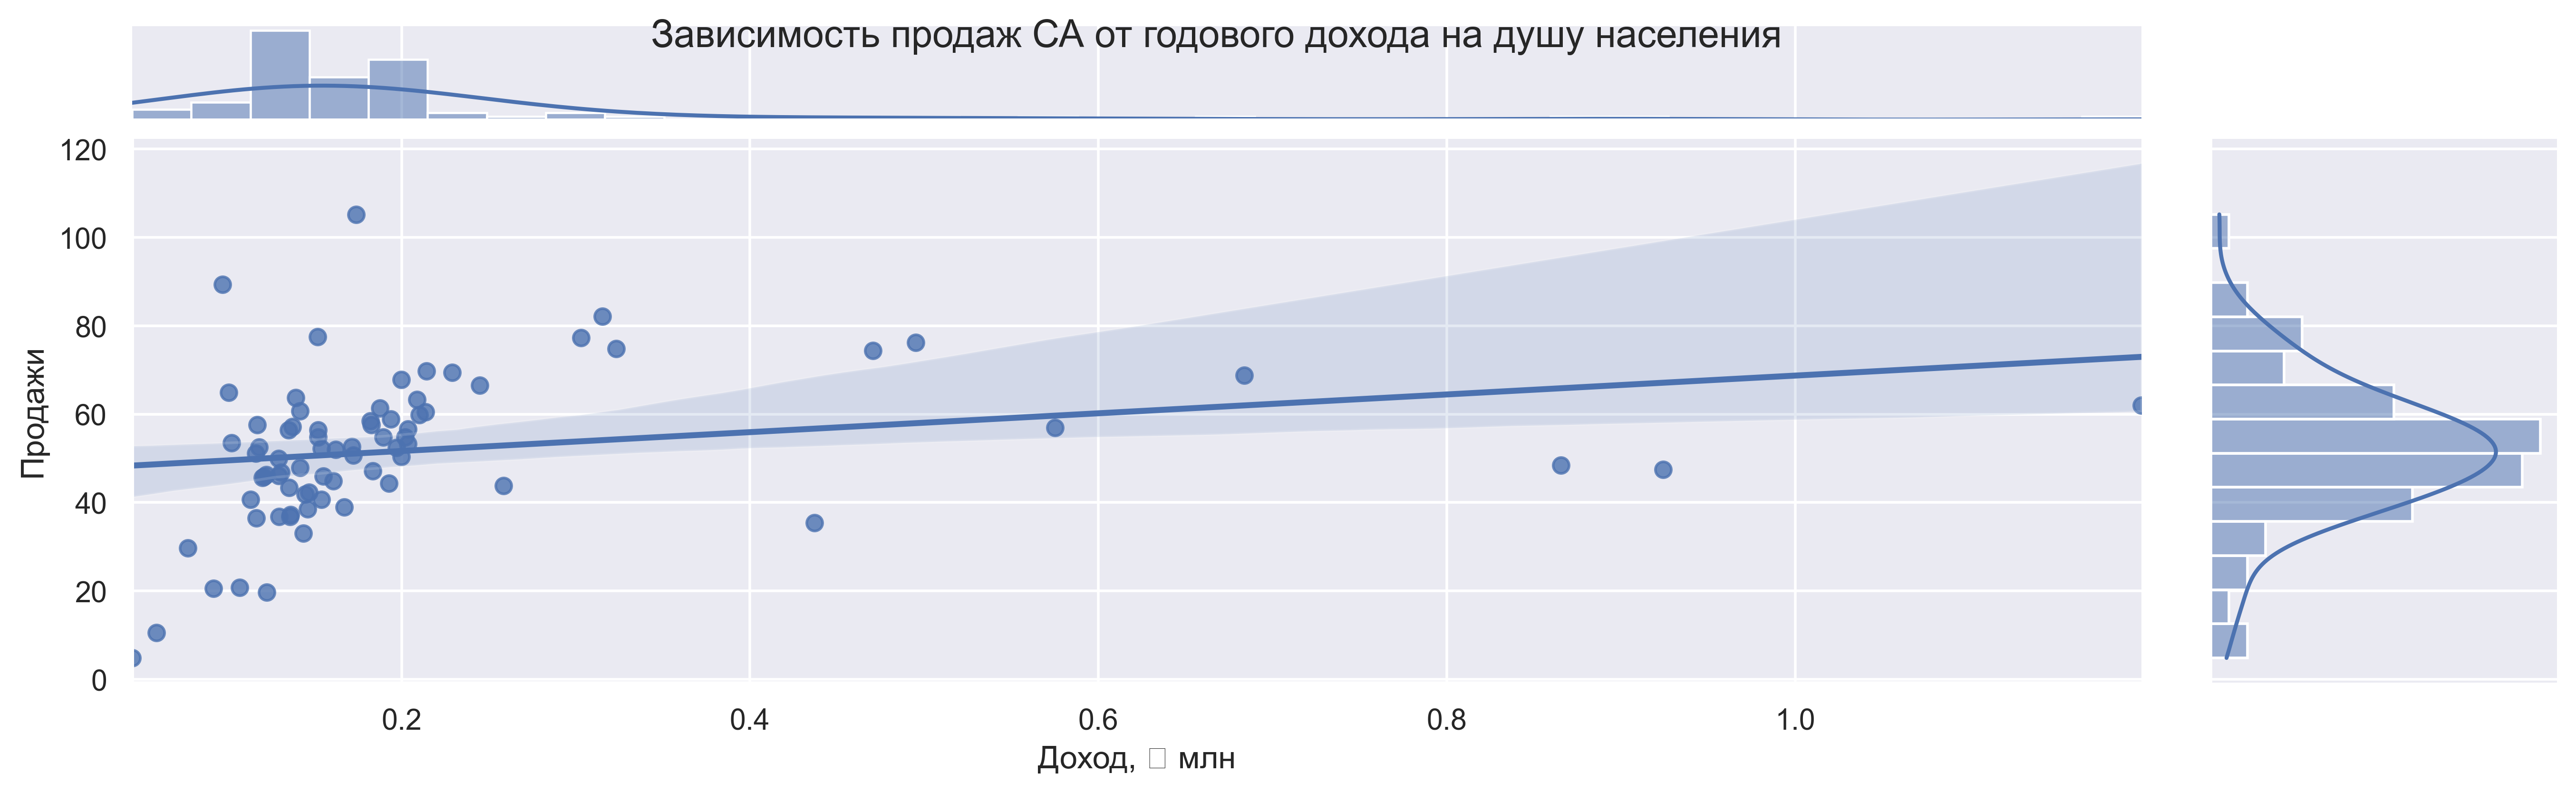

In [16]:
with Img('Зависимость продаж СА от годового дохода на душу населения'):
    sns.jointplot(x=data.income / 1000000, y=data.sales, kind='reg')
    Img.labels('Доход, ₽ млн', 'Продажи')

Из этого графика напрашиваются следующие выводы:
- Большинство зарплат всё-таки находится на приблизительно похожем уровне. Немногие регионы могут похвастаться высоким доходом населения.
- Но если попытаться выявить некую линейную зависимость между продажами и доходами, то с вероятностью 95% наши продажи будут лучше в регионах с хорошей зарплатой.

Проверим гипотезу о том, что в регионах с хорошими продажами лучше доход, чтобы говорить об этом с большей уверенностью. Для начала проверим распределения на нормальность.

In [17]:
# Оба ли распределения нормальные?
all(list(map(lambda x: shapiro(x).pvalue > 0.05, [top_sales.income, data.drop(top_sales.index).income])))

False

Снова берём критерий Манна-Уитни.

$H_0$: - доход населения в топ-10 регионах не выше, чем в остальных.

$H_1$: - доход в топ-10 регионах выше, чем в остальных регионах. 

In [18]:
# Проверим нулевую гипотезу
hypo(mannwhitneyu(top_sales.income, data.drop(top_sales.index).income, alternative='greater'))

p-value = 0.0054929659500858935
p-value < 0.05


**Нулевую гипотезу получилось опровергнуть**: что это значит?
- Если мы берём город с б**о**льшим доходом населения, то наши шансы на хорошую прибыль повышаются, а также понижаются шансы на сниженную прибыль.

---

### Вывод из анализа
- Мы изучили зависимость продаж слабоалкогольной продукции от некоторых демографических факторов в различных регионах России.
- Выявили топ-10 регионов по продажам СА на душу населения от 20 лет и выше и сравнили их со средним по всей стране.
- Попытались выявить возрастные группы в составе населения, наличие которых может быть связано с продажами СА:
    - Наше внимание привлекла категория 35-44-летних. В "продающих" регионах этих людей заметно больше, чем в среднем по остальным регионам.
    - Также в особо успешных районах больше подростков 10-19 лет. Неприятная новость, но дети вполне могут быть связаны с распитием подобных напитков.
    - Мы предположили, что родителям малышей интересны наши напитки, потому что в продающих регионах много детей до 4 лет.
    - В топ-10 регионов немного меньше доля людей от 55 и старше.
- Проверили предположение о том, что безработица способствует употреблению слабоалкогольных напитков, и выяснили прямо противоположное: **в регионах, где безработица выше, продажи оказываются ниже**.
- Исследовали зависимость потребления СА от уровня дохода в регионах:
    - Регрессионный анализ указывает на то, что продажи выше в регионах с более высоким доходом.
    - Проверка статистической гипотезы позволяет подтверждает эту разницу.

---

## Что дальше?
У нас появилось некоторое представление о том, какими признаками может обладать регион, в котором СА напитки будут продаваться лучше:
- Вероятно, он будет далеко от Москвы.
- Приоритет населения до 40-50 лет.
- Возможно, что родители с маленькими детьми поспособствуют продажам.
- Желательно безработица не выше 9%.
- Доход должен быть по возможности максимальным, чтобы повысить наши шансы на хорошие продажи.

Попробуем найти 10 потенциально успешных регионов по нашим параметрам.

In [19]:
# Создадим множество из наших топ-регионов
top_set = set(top_sales.index.to_list())

# Подберём регионы грубым образом по нашим найденным параметрам
recommended_set = set(data.sort_values([(40, 44), 'income', 'unemployed', (35, 39), (0, 4)],
                                       ascending=[False, False, True, False, False]).head(10).index)

In [20]:
# Посмотрим на пересечение поиска и реальных топ-10
top_set & recommended_set

{'        Камчатский край',
 '        Мурманская область',
 '        Республика Коми',
 '        Сахалинская область'}

- Даже **грубый поверхностный поиск** без задания каких-либо весов для признаков регионов **даёт нам 4 угаданных региона из топ-10** (при том, что всего их 76 вариантов). А это значит, что так или иначе **обнаруженные нами закономерности помогают принять решение** о том, какие регионы рассматривать в качестве потенциально выигрышных.
- Более точный поиск взаимосвязей можно поручить алгоритмам машинного обучения. Вполне вероятно, что даже линейная регрессия успешно справится с подбором региона.

---

## 3. Обучение модели

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from toads.ml import xy_split
from toads.eda import print_shapes

In [22]:
x, y = xy_split(data, 'sales', as_list=False)

In [23]:
xtr, xv, ytr, yv = train_test_split(x, y, random_state=42, test_size=.1)
print_shapes(xtr, xv, ytr, yv)

(68, 22)
(8, 22)
(68,)
(8,)


In [24]:
from time import time

In [25]:
def train_model(model, name=None, **kws):
    t1 = time()
    model.fit(xtr.values, ytr.values, **kws)
    t2 = time()
    preds = model.predict(x.values)
    t3 = time()
    return {'model': str(model) if not name else name,
            'mse': mean_squared_error(y, preds),
            'mae': mean_absolute_error(y, preds),
            'r2': 1/r2_score(y, preds),
            'fit_time': t2 - t1,
            'predict_time': t3 - t2}

#### Линейная регрессия

In [26]:
lr = train_model(LinearRegression(), 'linreg')

#### CatBoost

In [27]:
cb = train_model(CatBoostRegressor(verbose=False), 'catboost', eval_set=(xv, yv))

#### XGBoost

In [28]:
xgb = train_model(XGBRegressor(), 'xgboost', eval_set=[[xv.values, yv]], verbose=0)

#### LightGBM

In [29]:
lgb = train_model(LGBMRegressor(), 'lightgbm', eval_set=(xv.values, yv), verbose=0)

In [30]:
model_results = pd.DataFrame([lr, cb, xgb, lgb]).melt(id_vars='model',
                                                      value_vars=['mse', 'r2', 'mae', 'fit_time', 'predict_time'],
                                                      var_name='metric')
model_results.head()

,model,metric,value
0,linreg,mse,111.265856
1,catboost,mse,46.401512
2,xgboost,mse,57.587847
3,lightgbm,mse,105.337489
4,linreg,r2,1.681596


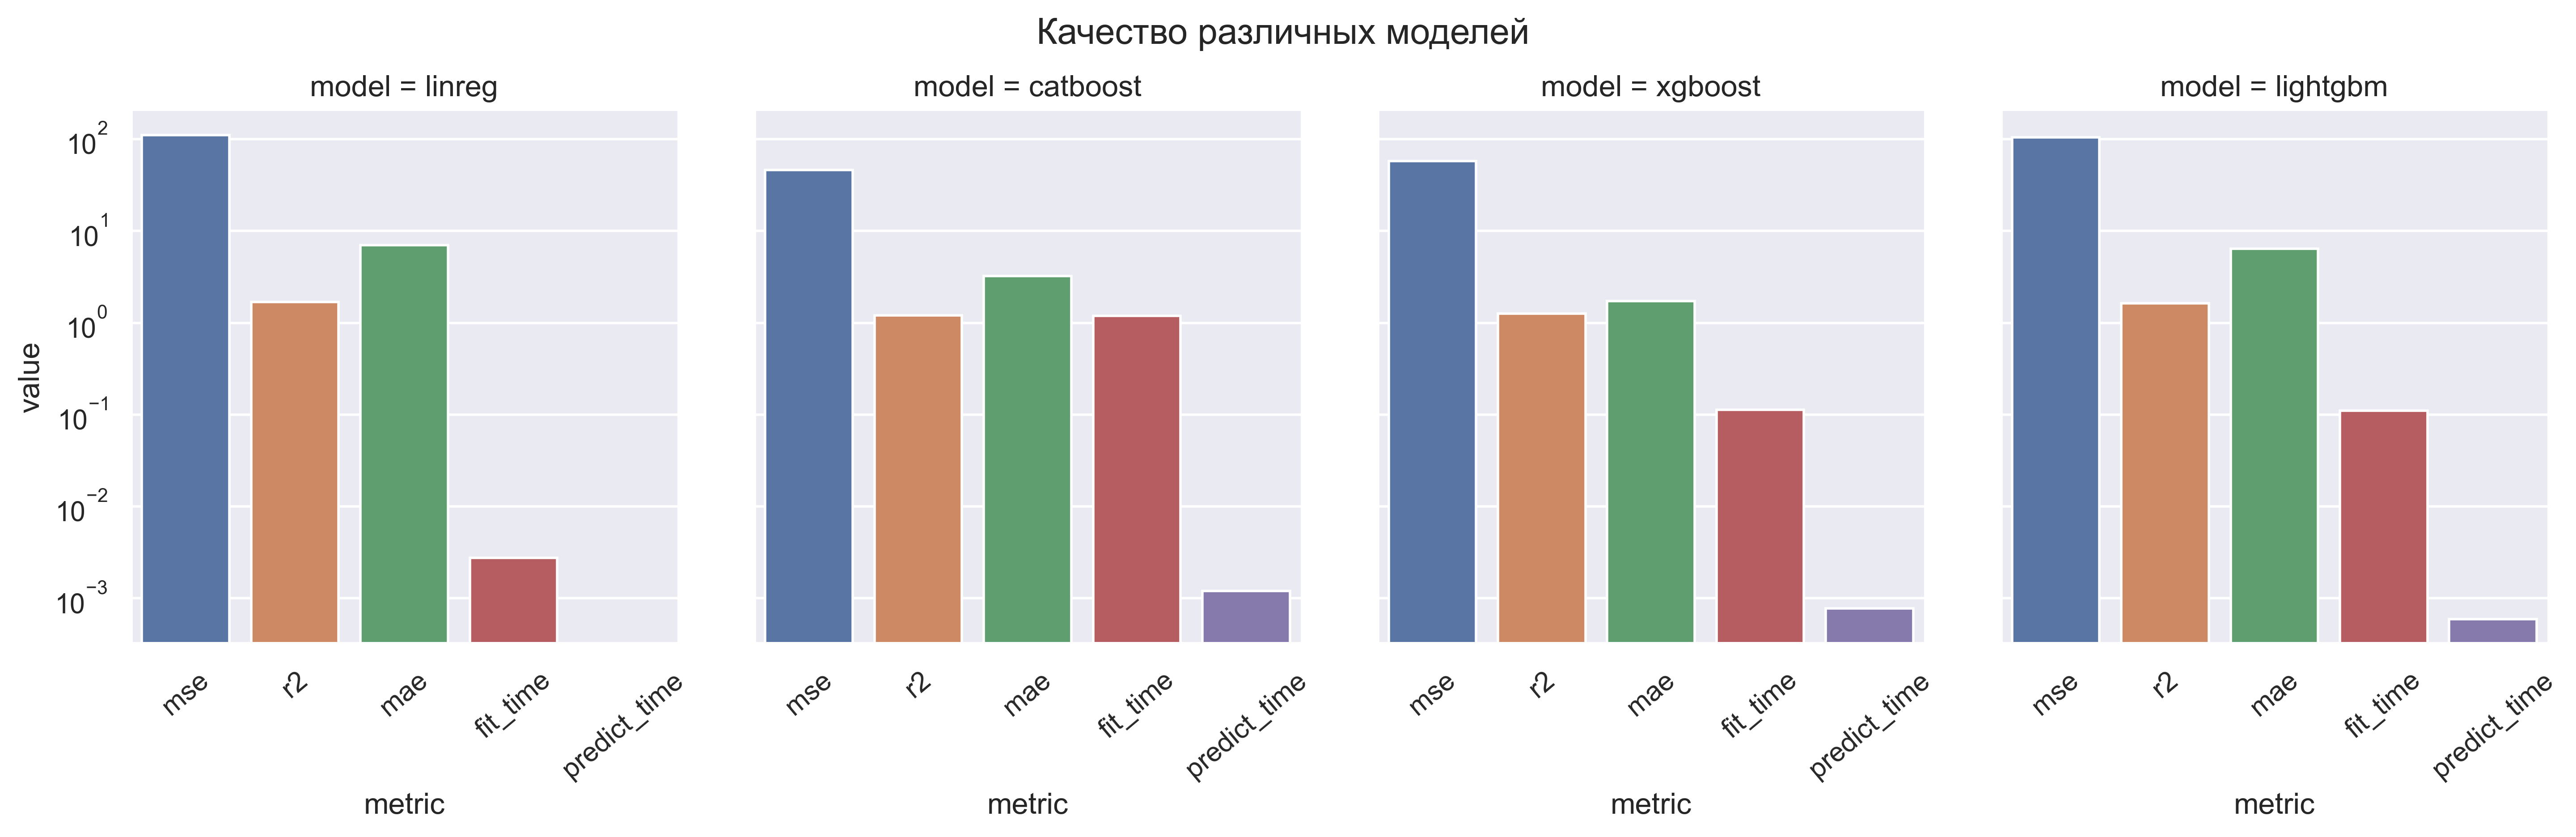

In [31]:
with Img('Качество различных моделей', y=5, tight=True):
    sns.catplot(x='metric', y='value', data=model_results, kind='bar', col='model')
    for ax in plt.gcf().axes:
        ax.tick_params(axis='x', rotation=40)
    plt.yscale('log')

Наиболее привлекательной выглядит **XGBoost**, поскольку для нас важнее всего качество предсказаний, а не их скоростная работа.

Попробуем дать нашей модели выбрать регионы автоматически.

In [32]:
# Обучим эталонную модель
model = XGBRegressor(n_estimators=100, random_state=42).fit(xtr.values, ytr.values,
                                                            verbose=20,
                                                            eval_set=[[xv.values, yv]],
                                                            early_stopping_rounds=50)

[0]	validation_0-rmse:50.61865
Will train until validation_0-rmse hasn't improved in 50 rounds.
[20]	validation_0-rmse:23.39946
[40]	validation_0-rmse:23.38848
[60]	validation_0-rmse:23.38987
[80]	validation_0-rmse:23.38986
Stopping. Best iteration:
[38]	validation_0-rmse:23.38770



## 4. Проверка модели
Допустим, у нас есть всего 10 регионов на выбор, и нам нужно выбрать один, в котором продажи потенциально будут наибольшими. ***Совпадёт ли выбор модели с реальным возможным максимумом?***

Проведём эксперимент 10000 раз, чтобы убедиться в качестве модели.

In [33]:
# Зафиксируем случайность
np.random.seed(12345)

# Будем записывать эксперименты в список
results = []
for i in range(10000):
    # Берётся 10 случайных регионов
    sample = data.sample(10)
    x_sample, y_sample = xy_split(sample, 'sales')
    
    # Находим лучший регион
    best_true = y_sample.argmax()
    
    # Модель пытается угадать лучший регион
    sample_preds = model.predict(x_sample.values)
    best_predicted = sample_preds.argmax()
    
    # Запоминаем результат
    results.append(best_true == best_predicted)

results = np.array(results)

В каком количестве случаев модель угадывает самый выгодный регион из возможных?

In [34]:
f'Доля идеальных ответов - {np.mean(results):.2%}'

'Доля идеальных ответов - 78.33%'

- Модель, которую мы обучили на микроскопическом количестве данных всего лишь за один год, в 78% случаев выбирает из случайно предложенных регионов не просто перспективный, а самый удачный.
- Стоит предположить, что при большем количестве данных и дальнейшем изучении жизни регионов мы сможем найти такие признаки, которые помогут нашей модели делать ещё более качественные предсказания.
- Если брать данные за несколько лет, то мы сможем работать с данными как со временным рядом и предсказывать динамику на будущее.

Какие характеристики регионов позволяют модели предсказывать продажи с такой точностью?

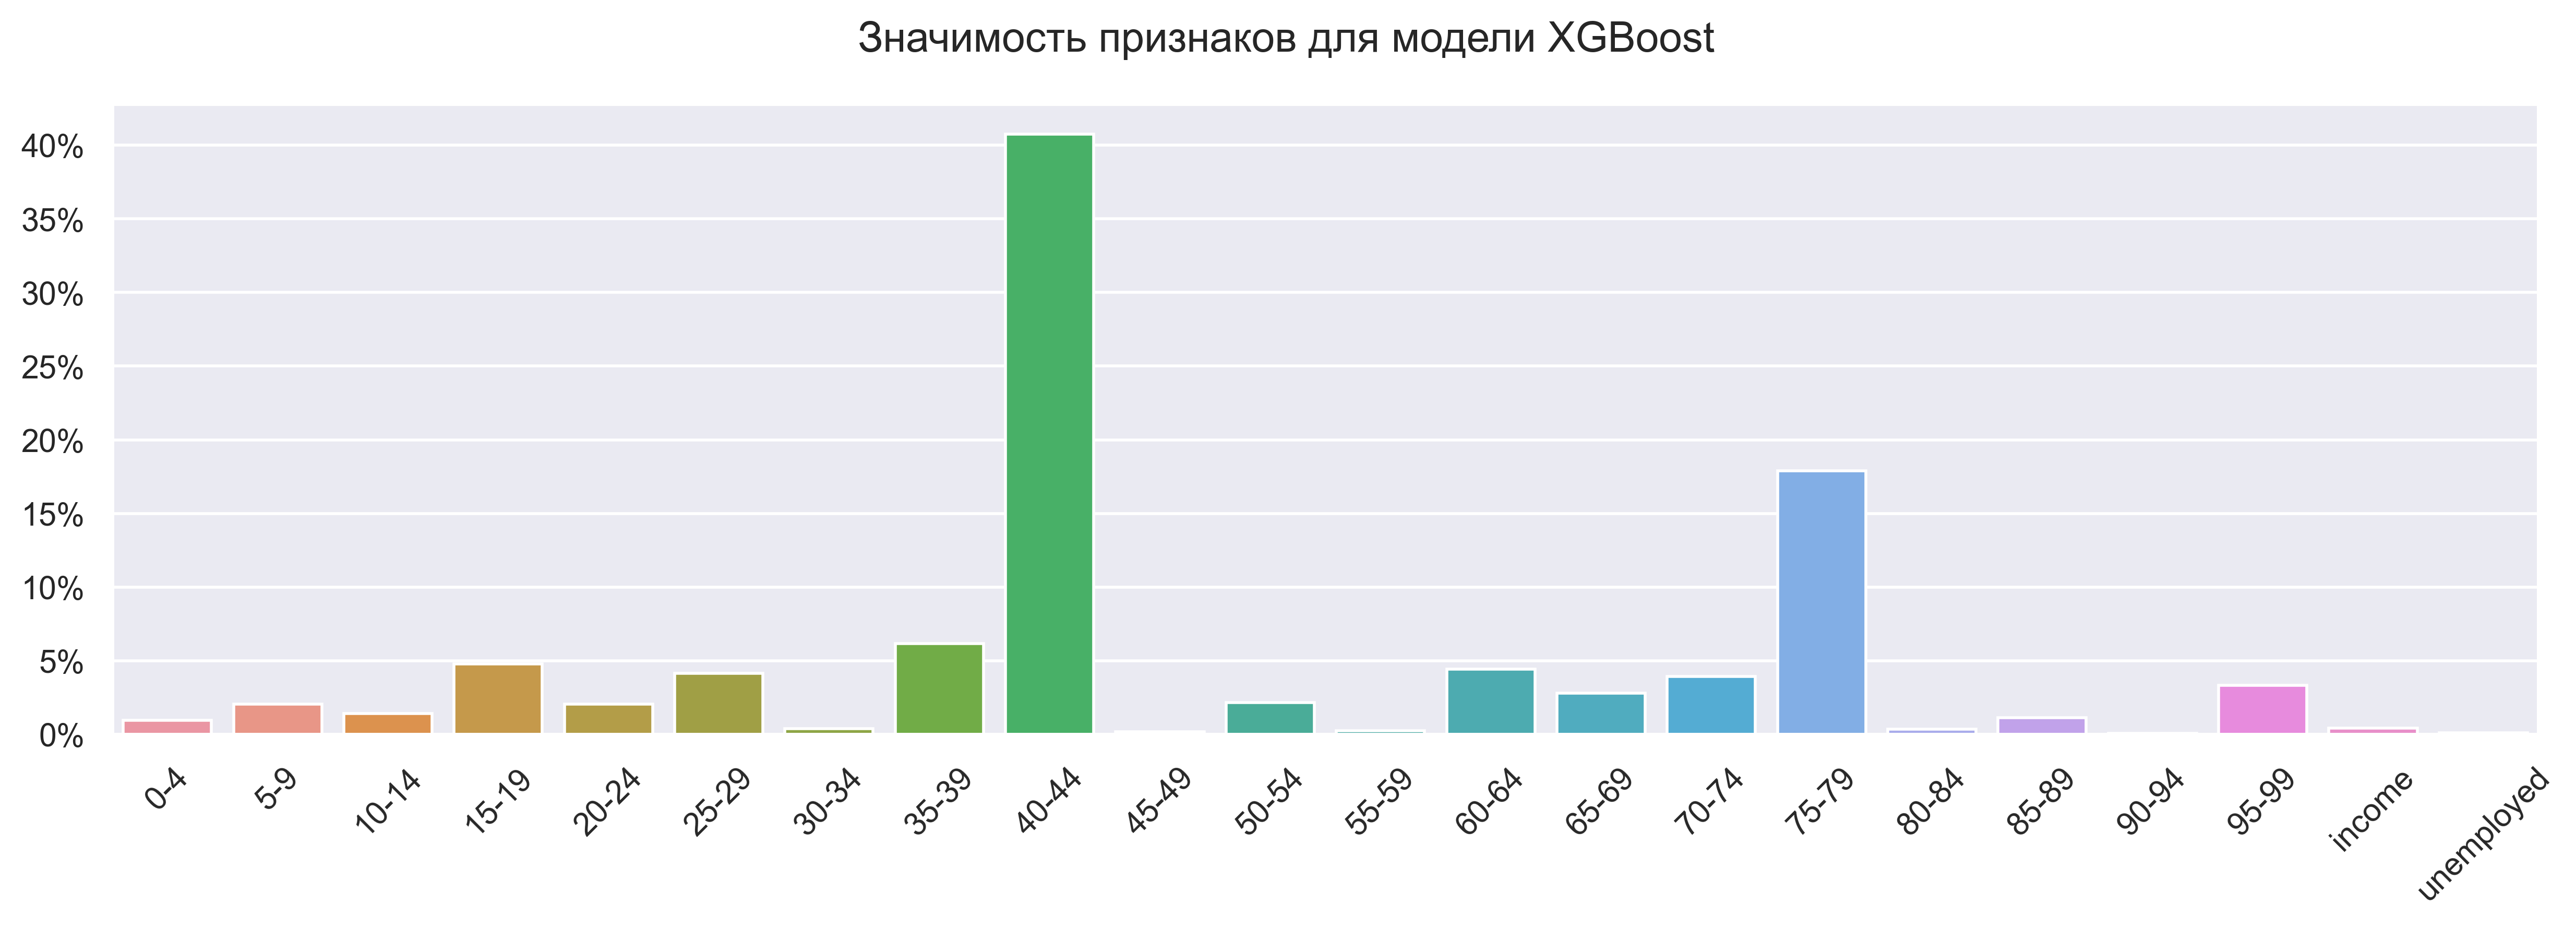

In [35]:
with Img('Значимость признаков для модели XGBoost'):
    sns.barplot(x=str_cols[:-1], y=model.feature_importances_)
    plt.xticks(rotation=45)
    Img.format_axis(1)

- Как мы и ожидали, 40-44-летние вносят наибольший вклад в оценку продаж СА.
- Доход населения оказался не особо важен для данной модели.
- Некоторые возрастные категории без видимой на то причины оказываются важнее остальных.
- Безработица имеет практически нулевую ценность для предсказаний.

\*К этой диаграмме не стоит относиться с большой серьёзностью, поскольку у нас очень маленький набор данных.

---